In [4]:
import os
import random
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [5]:
TRAIN_DIR = 'G:/Dataset/train'
CATEGORIES = []
for c in os.listdir(TRAIN_DIR):
    CATEGORIES.append(c)
print(CATEGORIES)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [6]:
TRAIN_DATA = []
for c in CATEGORIES:
    path = os.path.join(TRAIN_DIR,c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        img_arr = cv2.imread(os.path.join(path,img))
        TRAIN_DATA.append([img_arr, class_num])
print(len(TRAIN_DATA))

100%|██████████| 5000/5000 [00:38<00:00, 128.29it/s]

50000


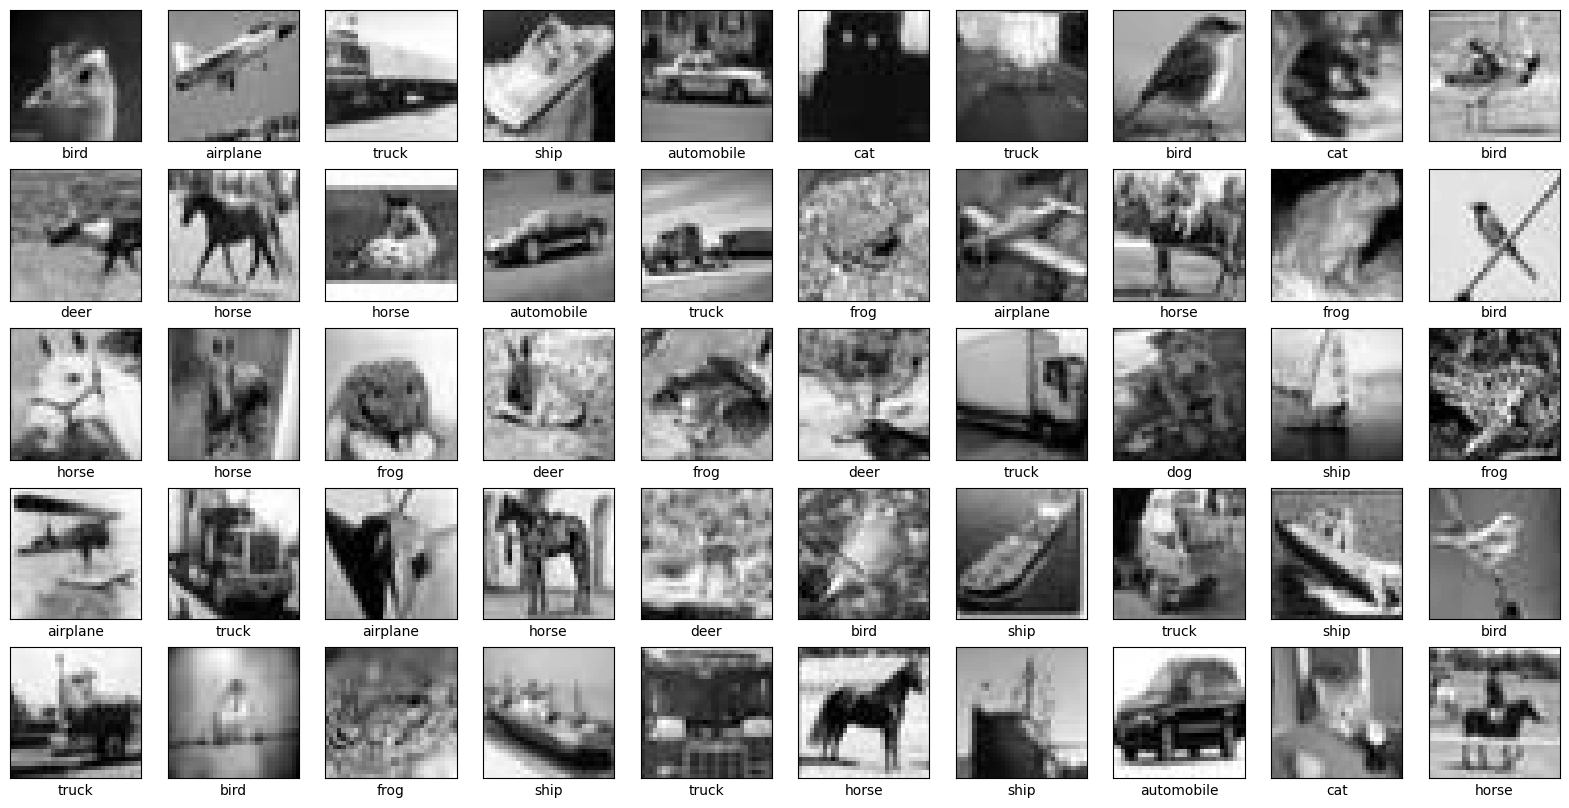

In [7]:
random.shuffle(TRAIN_DATA)
plt.figure(figsize=(20,10))
for i in range(50):
    plt.subplot(5,10,i+1)
    image = TRAIN_DATA[i][0]
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    plt.imshow(image_gray, cmap="gray")
    plt.xlabel(CATEGORIES[TRAIN_DATA[i][1]])
    plt.xticks([])
    plt.yticks([])
    if i==50:
        break
plt.show()

In [8]:
f0 = TRAIN_DATA[0:1000]
f1 = TRAIN_DATA[1000:2000]
f2 = TRAIN_DATA[2000:3000]
f3 = TRAIN_DATA[3000:4000]
f4 = TRAIN_DATA[4000:5000]

In [16]:
def by_l1_dist(list):
    return list[2]["l1"]

def by_l2_dist(list):
    return list[2]["l2"]

In [17]:
top_filter = 20
def distance_calc(train_fold, valid_fold):
    l1_result = []
    l2_result = []
    for valid in tqdm(valid_fold): 
        temp_dist_list = []
        for train in train_fold: 
            l1_dist = np.sum(np.abs(valid[0]-train[0]))
            l2_dist = np.sqrt(np.sum(valid[0]-train[0]**2))
            temp_dist_list.append([valid[1],  train[1], {"l1": l1_dist, "l2": l2_dist}])
        temp_dist_list.sort(key=by_l1_dist)
        l1_result.append(temp_dist_list[:top_filter])
        temp_dist_list.sort(key=by_l2_dist)
        l2_result.append(temp_dist_list[:top_filter])
    return [l1_result, l2_result]

In [18]:
k_range = 20
def cal_accuracy(dist_result, dist_term):
    k_accuracies = []  
    for k in range(1, k_range+1):
        img_accuracy = 0
        for valid_img in dist_result:
            nn = valid_img[:k]
            same_class = [n for n in nn if n[0] == n[1]]
            same_class_len = len(same_class)
            if k % 2 != 0:                      
                if ((k-1) / 2) < same_class_len:  
                    img_accuracy += 1
            else:                                  
                diff_class = [n for n in nn if n[0] != n[1]]
                if same_class_len > len(diff_class):    
                    img_accuracy += 1
                elif same_class_len == len(diff_class): # tie
                    same_class_dist = sum([n[2][dist_term] for n in same_class])
                    diff_class_dist = sum([n[2][dist_term] for n in diff_class])
                    if same_class_dist > diff_class_dist:   
                        img_accuracy += 1
        k_accuracies.append(img_accuracy/len(dist_result))
    return k_accuracies

In [19]:
dist_by_fold = []
import math 
for i in range(5):
    if i==0:
        train = f1+f2+f3+f4
        validation = f0    
    elif i==1:
        train = f0+f2+f3+f4
        validation = f1
    elif i==2:
        train = f1+f0+f3+f4
        validation = f2
    elif i==3:
        train = f1+f2+f0+f4
        validation = f3
    elif i==4:
        train = f1+f2+f3+f0
        validation = f4
    
    dist_by_fold.append(distance_calc(train, validation))  

100%|██████████| 1000/1000 [01:57<00:00,  8.48it/s]


In [20]:
accuracies = []

for result in dist_by_fold:
    l1_accuracy = cal_accuracy(result[0], "l1")
    l2_accuracy = cal_accuracy(result[1], "l2")
    accuracies.append([l1_accuracy, l2_accuracy])


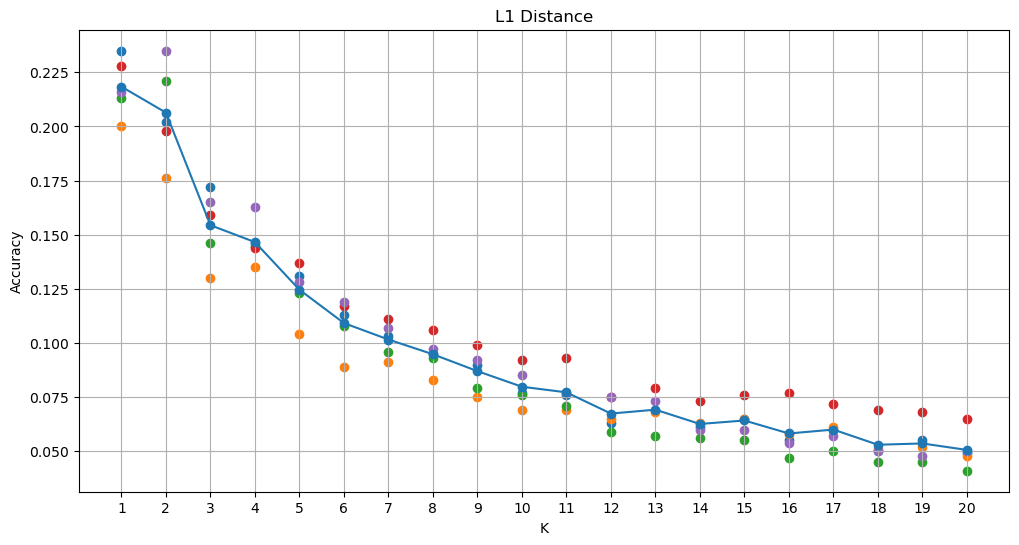

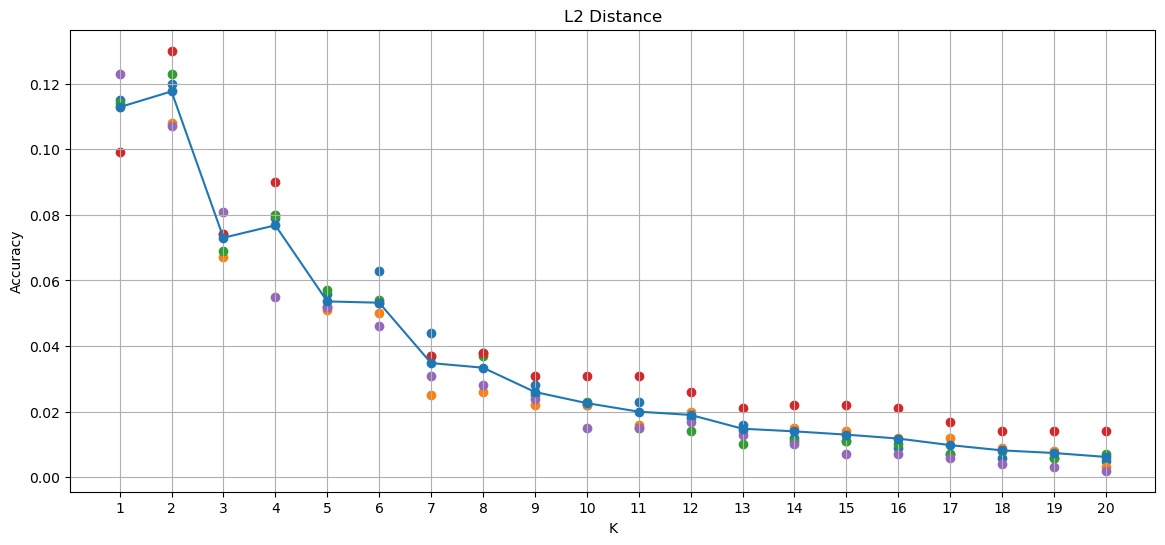

In [23]:

x_list = list(range(1, k_range+1))
plt.figure(figsize=(12, 6))

for fold in accuracies:
  y_list = fold[0]
  plt.scatter(x_list, y_list)
arr = []
for i in range(k_range):
  arr.append([fold[0][i] for fold in accuracies])
trend = [np.mean(a) for a in arr]
plt.errorbar(x_list, trend,fmt='-o')
plt.title('L1 Distance')
plt.xticks(x_list)
plt.grid(True)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()

x_list = list(range(1, k_range+1))
plt.figure(figsize=(14, 6))

for fold in accuracies:
  y_list = fold[1]
  plt.scatter(x_list, y_list)
arr = []
for i in range(k_range):
  arr.append([fold[1][i] for fold in accuracies])
trend = [np.mean(a) for a in arr]
plt.errorbar(x_list, trend,fmt='-o')
plt.title('L2 Distance')
plt.xticks(x_list)
plt.grid(True)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()

Top 5 Predictions for L1 Distance:
Prediction 1: Class 'frog' with L1 distance 0.00
Prediction 2: Class 'frog' with L1 distance 518.24
Prediction 3: Class 'airplane' with L1 distance 742.61
Prediction 4: Class 'cat' with L1 distance 750.62
Prediction 5: Class 'frog' with L1 distance 767.43

Top 5 Predictions for L2 Distance:
Prediction 1: Class 'frog' with L2 distance 0.00
Prediction 2: Class 'frog' with L2 distance 264.80
Prediction 3: Class 'dog' with L2 distance 297.18
Prediction 4: Class 'airplane' with L2 distance 300.15
Prediction 5: Class 'airplane' with L2 distance 301.15


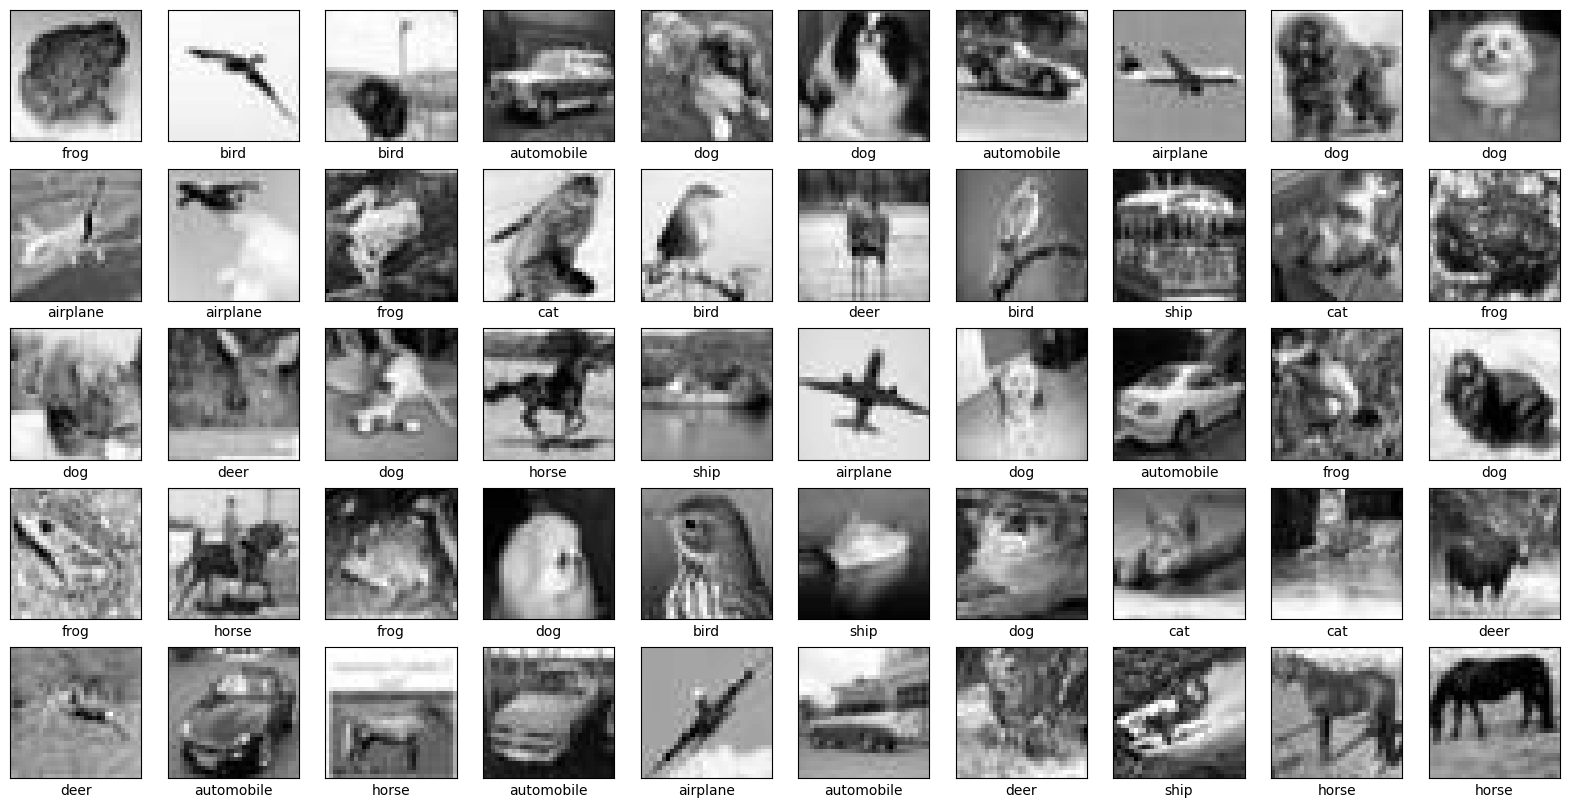

In [31]:
def l1_dist(image1, image2):
    return np.sum(np.abs(image1 - image2))

def l2_dist(image1, image2):
    return np.sqrt(np.sum((image1 - image2) ** 2))

random.shuffle(TRAIN_DATA)
plt.figure(figsize=(20, 10))
for i in range(50):
    plt.subplot(5, 10, i+1)
    image = TRAIN_DATA[i][0]
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    plt.imshow(image_gray, cmap="gray")
    plt.xlabel(CATEGORIES[TRAIN_DATA[i][1]])
    plt.xticks([])
    plt.yticks([])
    if i == 49: 
        break
test_images = [] 

for i in range(2000):
    test_image = TRAIN_DATA[i][0] 
    test_image_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY) 
    test_images.append(test_image_gray) 

print("Top 5 Predictions for L1 Distance:")
for test_image_gray in test_images:
    distances1 = []
    for train_image, class_num in TRAIN_DATA:
        train_image_gray = cv2.cvtColor(train_image, cv2.COLOR_BGR2GRAY) 
        dist1 = l1_dist(test_image_gray, train_image_gray) 
        distances1.append((dist1, class_num))
    distances1.sort(key=lambda x: x[0]) 
    
    for i, (dist1, class_num) in enumerate(distances1[:5]):
        predicted_class = CATEGORIES[class_num]
        print(f"Prediction {i+1}: Class '{predicted_class}' with L1 distance {dist1/100:.2f}")
    break
    

print("\nTop 5 Predictions for L2 Distance:")
for test_image_gray in test_images:
    distances2 = []
    for train_image, class_num in TRAIN_DATA:
        train_image_gray = cv2.cvtColor(train_image, cv2.COLOR_BGR2GRAY) 
        dist2 = l2_dist(test_image_gray, train_image_gray) 
        distances2.append((dist2, class_num))
    distances2.sort(key=lambda x: x[0]) 

    for i, (dist2, class_num) in enumerate(distances2[:5]):
        predicted_class = CATEGORIES[class_num]
        print(f"Prediction {i+1}: Class '{predicted_class}' with L2 distance {dist2:.2f}")   
    break